In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.random.seed(0)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person

# Pneumania Classification : Transfered CNN

# What exactly is Pneumania : Why we should pay attention to it?

![Pneumonia](https://upload.wikimedia.org/wikipedia/commons/2/23/Lobar_pneumonia_illustrated.jpg)

> Pneumonia is an **inflammatory condition of the lung primarily affecting the small air sacs known as alveoli**. Symptoms typically include some combination of productive or **dry cough, chest pain, fever and difficulty breathing**. The severity of the condition is variable. Pneumonia is **usually caused by infection with viruses or bacteria**, and less commonly by other microorganisms. Identifying the responsible pathogen can be difficult. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.[1]

> According to WHO, Pneumonia is the single **largest infectious cause of death in children worldwide**. Pneumonia killed 808 694 children under the age of 5 in 2017, accounting for 15% of all deaths of children under five years old. Pneumonia affects children and families everywhere, but is most prevalent in South Asia and sub-Saharan Africa. Children can be protected from pneumonia, it can be prevented with simple interventions, and treated with low-cost, low-tech medication and care.[2]

Therefore, the earlier detection of Pneumania, the better chance of survival of children. In this study we'll focus on building a model to help doctor classifying chest x-rays images to identify which patiences has Pneumonia or not?

# Data Explanation
![Example](https://i.imgur.com/jZqpV51.png)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# Data preparation

In [2]:
# Define our example directories and files
base_dir = '../input/chest-xray-pneumonia/chest_xray'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'val')
test_dir = os.path.join( base_dir,'test')

train_NORMAL_dir = os.path.join(train_dir, 'NORMAL') 
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')
validation_NORMALs_dir = os.path.join(validation_dir, 'NORMAL')
validation_PNEUMONIA_dir = os.path.join(validation_dir, 'PNEUMONIA')
test_NORMAL_dir = os.path.join(test_dir, 'NORMAL')
test_PNEUMONIA_dir = os.path.join(test_dir, 'PNEUMONIA')


train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)
validation_NORMAL_fnames = os.listdir(validation_NORMALs_dir)
validation_PNEUMONIA_fnames = os.listdir(validation_PNEUMONIA_dir)

#ratio of training set
train_ratio = (len(train_PNEUMONIA_fnames) + len(train_NORMAL_fnames))/(len(train_PNEUMONIA_fnames) + len(train_NORMAL_fnames)+len(validation_NORMAL_fnames) + len(validation_PNEUMONIA_fnames))

print(f'NORMAL class in Training set = {len(train_NORMAL_fnames)} : {round(len(train_NORMAL_fnames)/(len(train_NORMAL_fnames)+len(train_PNEUMONIA_fnames)),3)*100}%')
print(f'PNEUMONIA class in Training set = {len(train_PNEUMONIA_fnames)} : {round(len(train_PNEUMONIA_fnames)/(len(train_NORMAL_fnames)+len(train_PNEUMONIA_fnames)),3)*100}%')
print(f'Training set : Validation set ratio = {round(train_ratio*100,1)}% : {round((1-train_ratio)*100,1)}%')

NORMAL class in Training set = 1341 : 25.7%
PNEUMONIA class in Training set = 3875 : 74.3%
Training set : Validation set ratio = 99.7% : 0.3%


**Cautions!**
* We might experience class imbalanced problem. We should be awared that classification accuracy is not a good evaluating metrics in this case.
* Training/Validation set split is too extreme. With this size of validation set, our model may not generalized enough. To fix this I'll re-split train:val set to have more proper ratio

In [3]:
old_train_set = []
old_validation_set = []

for (dirpath, dirnames, filenames) in os.walk(train_dir):
    old_train_set += [os.path.join(dirpath, file) for file in filenames]
for (dirpath, dirnames, filenames) in os.walk(validation_dir):
    old_validation_set += [os.path.join(dirpath, file) for file in filenames]

full_train_set = old_train_set + old_validation_set #combine old training and validation set together for further splitting
full_train_set = pd.DataFrame({'abs_path' : full_train_set}) #put path into 
full_train_set.loc[full_train_set['abs_path'].str.contains('NORMAL'), 'Class'] = 'NORMAL'
full_train_set.loc[full_train_set['abs_path'].str.contains('PNEUMONIA'), 'Class'] = 'PNEUMONIA'
full_train_set.sample(5)

,abs_path,Class
2830,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
4376,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
4294,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
1977,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
3788,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA


In [4]:
X = full_train_set['abs_path']
y = full_train_set['Class']


val_split = 0.2

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = val_split,stratify=y,random_state=42)

train_set = pd.DataFrame({'abs_path':X_train,'Class':y_train})
validation_set = pd.DataFrame({'abs_path':X_val,'Class':y_val})

In [5]:
datagen = ImageDataGenerator(rescale=1./255,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train Image Generator
train_generator=datagen.flow_from_dataframe(
dataframe=train_set,
x_col="abs_path",
y_col="Class",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

#Validation Image Generator
validation_generator=test_datagen.flow_from_dataframe(
dataframe=validation_set,
x_col="abs_path",
y_col="Class",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

#Test Image Generator
test_generator = test_datagen.flow_from_directory(
test_dir,
batch_size=32,
shuffle=False,    
class_mode="binary",
target_size = (150,150))

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
normal_count = 0
pneumonia_count = 0
for i in range(len(train_generator.labels)):
    if train_generator.labels[i] == 0:
        normal_count += 1
    else:
        pneumonia_count += 1
        
assert(normal_count+pneumonia_count==len(train_generator.labels))


normal_weight = pneumonia_count/normal_count
pneumonia_weight = 1

class_weight = {0:normal_weight,1:pneumonia_weight}
print(class_weight)

{0: 2.8785912882298423, 1: 1}


In [7]:
val_normal_count = 0
val_pneumonia_count = 0
for i in range(len(validation_generator.labels)):
    if validation_generator.labels[i] == 0:
        val_normal_count += 1
    else:
        val_pneumonia_count += 1
        
print(f'normal in train set = {normal_count}')
print(f'pneumonia in train set = {pneumonia_count}')
print(f'normal in val set = {val_normal_count}')
print(f'pneumonia in val set = {val_pneumonia_count}')

normal in train set = 1079
pneumonia in train set = 3106
normal in val set = 270
pneumonia in val set = 777


Looking good! We've managed to solve extreme training and validation set split from 99:1 ratio to 80:20 ratio with stratified class.

# Dataset Visualization

Let's have a look what our dataset look like ...

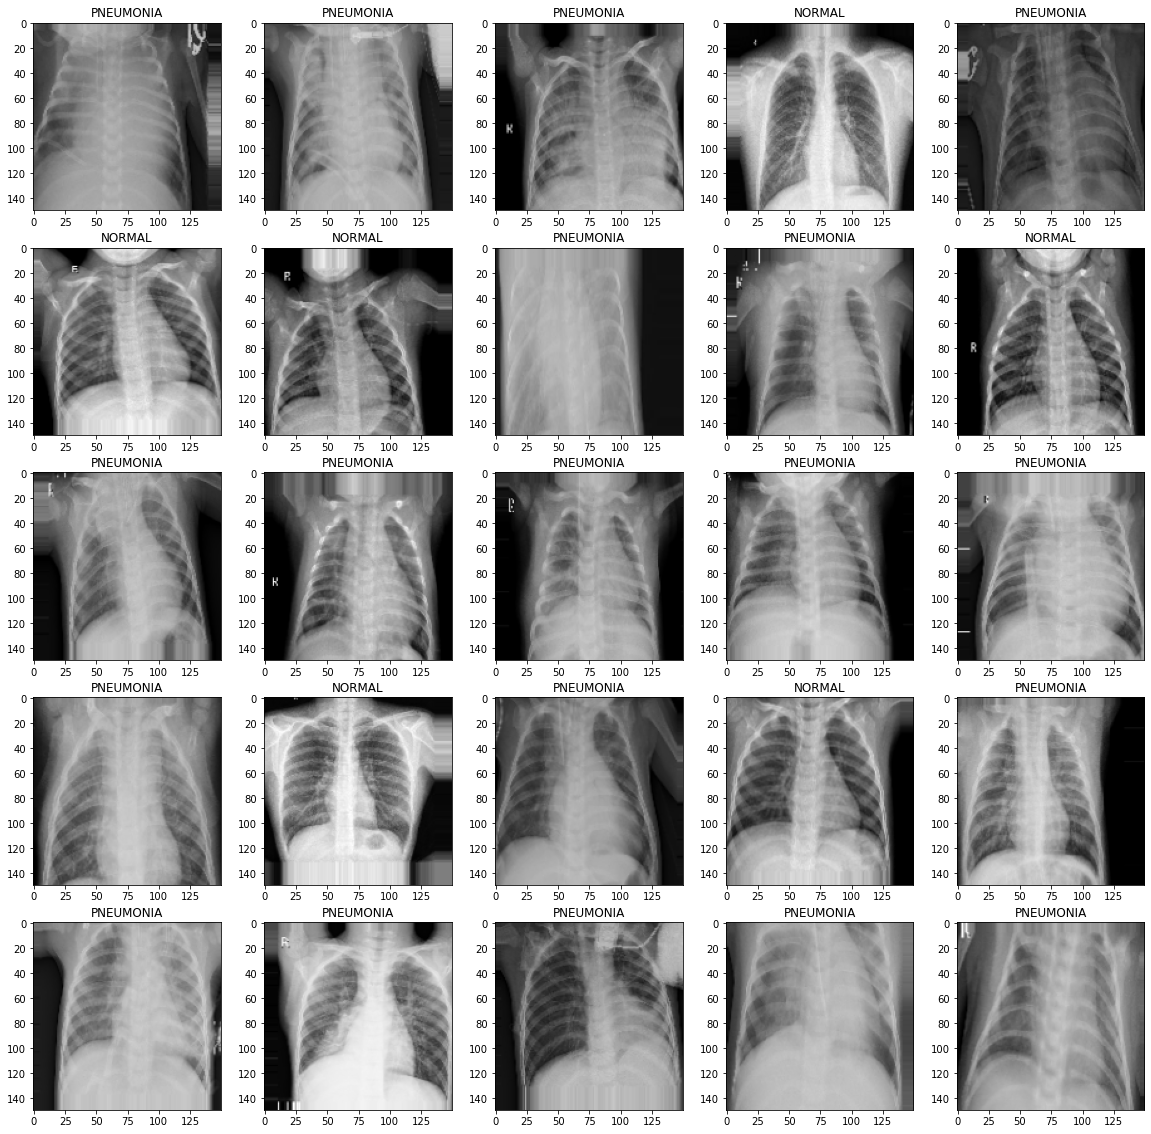

In [8]:
x_batch, y_batch = next(train_generator)
fig = plt.figure(figsize = (20,20))

for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_batch[i])
    if y_batch[i] == 1:
        plt.title('PNEUMONIA')
    else:
        plt.title('NORMAL')


From sample of our dataset, 

* Chest x-rays for people who are healthy (NORMAL) are clearer, minimal white shaded in lung area
* On the other hand, for people who have Pneumonia, their x-rays image seem more opaque. 

# Model Buidling

![VGG-16 architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

To save time for model development, I decide to use pretrained VGG16 model from Tensorflow [3] you can try other model to see the different

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

def create_model():
    
    pre_trained_model = VGG16(input_shape=(150,150,3),include_top=False)
    
    #freeze layers weight 
    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    
    last_layer = pre_trained_model.get_layer('block5_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    
    
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 128 hidden units and ReLU activation
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)           
    
    METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
    ]
    
    
    model = Model(pre_trained_model.input, x) 
    
    model.compile(optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9),
                  loss = 'binary_crossentropy', 
                  metrics = METRICS)
    
    model.summary()

    return model

In [10]:
#Training hyperparameters
batch_size = 32
steps_per_epoch = len(train_generator.labels) // batch_size
validation_step = len(validation_generator.labels) // batch_size
epochs = 30

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

baseline_model = create_model()
baseline_history = baseline_model.fit(train_generator,
        validation_data = validation_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        validation_steps = validation_step,
        callbacks = [early_stopping]
                            );



58892288/58889256 [==============================] - 1s 0us/step
last layer output shape:  (None, 4, 4, 512)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
___________

In [11]:
plt.style.use('ggplot')
from sklearn.metrics import confusion_matrix, roc_curve
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    fig = plt.figure(figsize=(10,10))
    fig.suptitle('Preliminary performance of model', fontsize=16, y=1.05)
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        sns.lineplot(history.epoch,  history.history[metric], label='Train')
        sns.lineplot(history.epoch, history.history['val_'+metric] ,label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])
    
        plt.legend()
        
    fig.tight_layout(pad=1.0)

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Normal Chest X-rays Detected (True Negatives): ', cm[0][0])
    print('Normal Chest X-rays Incorrectly Detected (False Positives): ', cm[0][1])
    print('Pneumonia Chest X-rays Missed (False Negatives): ', cm[1][0])
    print('Pneumonia Chest X-rays Detected (True Positives): ', cm[1][1])
    print('Total Pneumonia Chest X-rays : ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions,zoom=False, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    if zoom == True:
        plt.xlim([-0.5,20])
        plt.ylim([80,100.5])
    else:
        plt.xlim([-0.5,100])
        plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

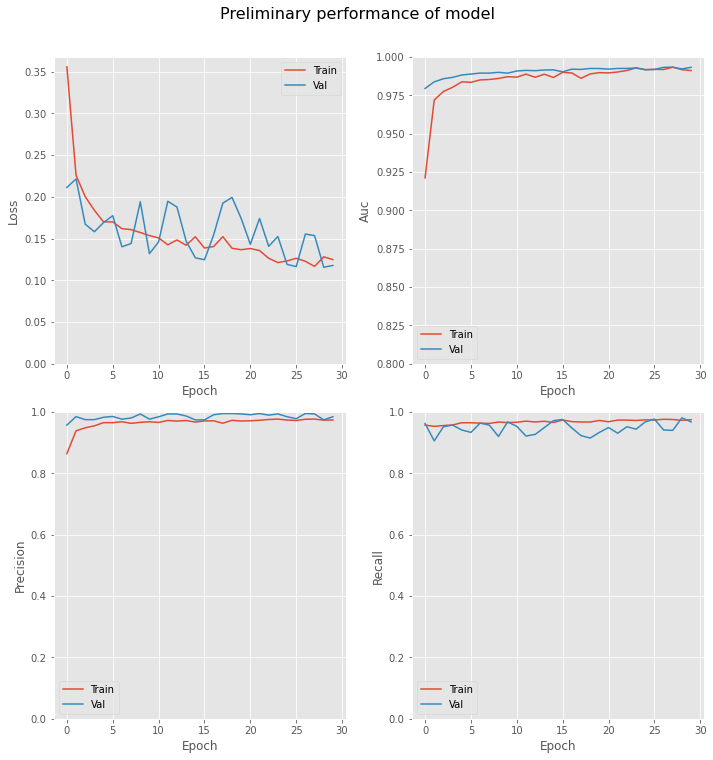

In [12]:
plot_metrics(baseline_history)

In [13]:
train_prediction_baseline = baseline_model.predict(train_generator, batch_size = batch_size)
test_prediction_baseline = baseline_model.predict(test_generator, batch_size = batch_size)

Normal Chest X-rays Detected (True Negatives):  153
Normal Chest X-rays Incorrectly Detected (False Positives):  81
Pneumonia Chest X-rays Missed (False Negatives):  2
Pneumonia Chest X-rays Detected (True Positives):  388
Total Pneumonia Chest X-rays :  390


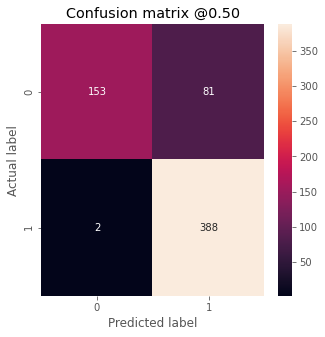

In [14]:
plot_cm(test_generator.labels,test_prediction_baseline)

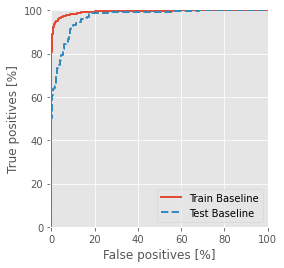

In [15]:
plot_roc("Train Baseline", train_generator.labels,train_prediction_baseline)
plot_roc("Test Baseline", test_generator.labels,test_prediction_baseline, linestyle='--')
plt.legend(loc='lower right')

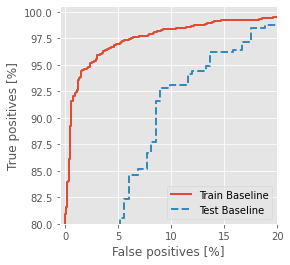

In [16]:
plot_roc("Train Baseline", train_generator.labels,train_prediction_baseline,zoom=True)
plot_roc("Test Baseline", test_generator.labels,test_prediction_baseline, linestyle='--',zoom=True)
plt.legend(loc='lower right')

Baseline performance are poor. The model wrongly classify normal chest x-rays into Pneumonia case which may result in too much workload for examiner. But the good things is there is minimal amount of Pneumonia chest x rays wrongly classified as normal chest x-rays.

Let's see how can we improve the model by 

1. Introduce class weight into the model to overcome imbalanced class problem
1. Use of ReduceLRonPlateau and Checkpoint callback
1. Unfreeze some layer of VGG16 and train it

# Fine tune the model

In [17]:
#Checkpoint callback

checkpoint = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",monitor='val_loss',save_best_only=True)

#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_lr=0.0001)

In [18]:
finetuned_model = create_model()
#load weight from baseline model
finetuned_model.set_weights(baseline_model.get_weights());

last layer output shape:  (None, 4, 4, 512)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

In [19]:
#train some VGG16 layers
# for count,layer in enumerate(finetuned_model.layers):
#     if count in np.arange(15,23).tolist():
#         layer.trainable = True
        
METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
    ]

    
finetuned_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
            loss = 'binary_crossentropy', 
            metrics = METRICS)
finetuned_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [20]:
epochs = 100
finetuned_history = finetuned_model.fit(train_generator,
        validation_data = validation_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        validation_steps = validation_step,
        class_weight=class_weight, #introduce class weight into model training
        callbacks = [early_stopping,checkpoint,reduce_lr]
                            ) 

Epoch 1/100
130/130 [==============================] - 93s 718ms/step - loss: 0.2116 - tp: 2926.0000 - fp: 43.0000 - tn: 1025.0000 - fn: 159.0000 - accuracy: 0.9514 - precision: 0.9855 - recall: 0.9485 - auc: 0.9891 - val_loss: 0.1674 - val_tp: 712.0000 - val_fp: 4.0000 - val_tn: 260.0000 - val_fn: 48.0000 - val_accuracy: 0.9492 - val_precision: 0.9944 - val_recall: 0.9368 - val_auc: 0.9933
Epoch 2/100
130/130 [==============================] - 92s 706ms/step - loss: 0.2045 - tp: 2922.0000 - fp: 40.0000 - tn: 1029.0000 - fn: 162.0000 - accuracy: 0.9514 - precision: 0.9865 - recall: 0.9475 - auc: 0.9906 - val_loss: 0.1129 - val_tp: 744.0000 - val_fp: 16.0000 - val_tn: 248.0000 - val_fn: 16.0000 - val_accuracy: 0.9688 - val_precision: 0.9789 - val_recall: 0.9789 - val_auc: 0.9922
Epoch 3/100
130/130 [==============================] - 93s 718ms/step - loss: 0.2309 - tp: 2890.0000 - fp: 51.0000 - tn: 1017.0000 - fn: 195.0000 - accuracy: 0.9408 - precision: 0.9827 - recall: 0.9368 - auc: 0.

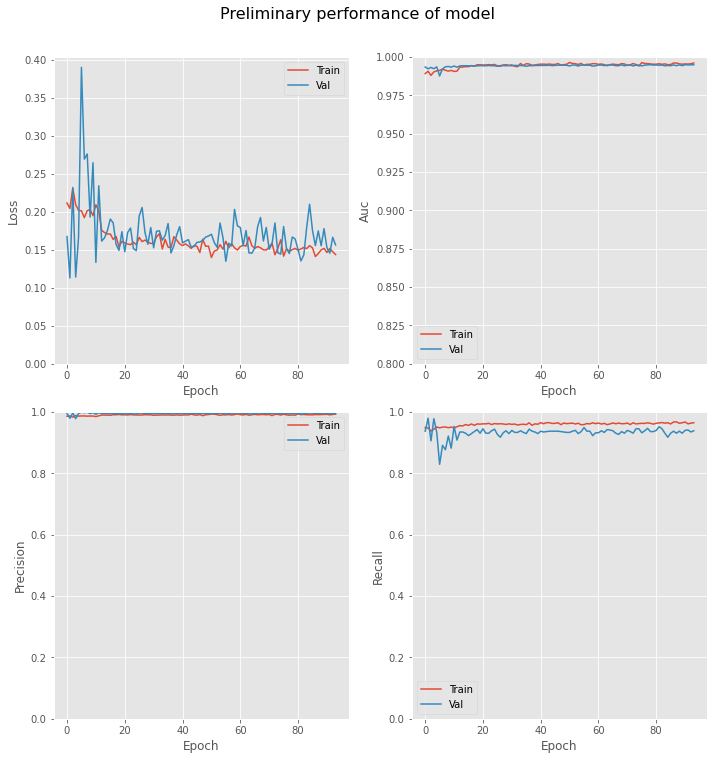

In [21]:
plot_metrics(finetuned_history)

In [22]:
train_prediction_finetuned = finetuned_model.predict(train_generator, batch_size = batch_size)
test_prediction_finetuned = finetuned_model.predict(test_generator, batch_size = batch_size)

Normal Chest X-rays Detected (True Negatives):  193
Normal Chest X-rays Incorrectly Detected (False Positives):  41
Pneumonia Chest X-rays Missed (False Negatives):  5
Pneumonia Chest X-rays Detected (True Positives):  385
Total Pneumonia Chest X-rays :  390


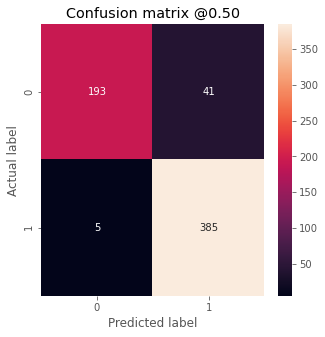

In [23]:
plot_cm(test_generator.labels,test_prediction_finetuned)

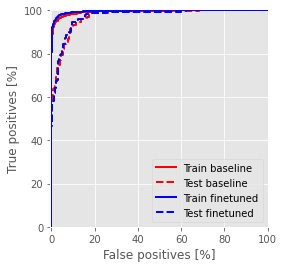

In [24]:
plot_roc("Train baseline", train_generator.labels,train_prediction_baseline,color='r')
plot_roc("Test baseline", test_generator.labels,test_prediction_baseline, linestyle='--',color='r')
plot_roc("Train finetuned", train_generator.labels,train_prediction_finetuned,color='b')
plot_roc("Test finetuned", test_generator.labels,test_prediction_finetuned, linestyle='--',color='b')
plt.legend(loc='lower right')

In [25]:
finetuned_results = finetuned_model.evaluate(test_generator,batch_size=batch_size, verbose=0)
for name, value in zip(finetuned_model.metrics_names, finetuned_results):
    print(name, ': ', value)

loss :  0.27102285623550415
tp :  385.0
fp :  41.0
tn :  193.0
fn :  5.0
accuracy :  0.9262820482254028
precision :  0.9037558436393738
recall :  0.9871794581413269
auc :  0.9681130647659302


# Conclusion

With limited time, we're able to build x-rays image classifier to classify to correctly predict Pneumonia chest x-rays with minimal Pneumonia cases wrongly classify as Normal (FN). Then we try to improve model performance by fine tuning with class weight and few techniques. We have acheive some improvement, but our model still have high amount of false positive (Normal case wrongly classify as Pneumonia)

We can see that our accuracy on test set is about 80% (relatively lower than accuracy in training and validation set). This indicate significant level of overfitting. Try reduce model complexity by cutting off some layers of VGG16 and adjust regularization parameters such as drop out rate and L2 regularization in Dense layers may help.

Our recall is greater than our precision, which mean that almost all pneumonia x-ray images are correctly classified (which is our main objective) but there are some normal images wrongly identified. I will study further on how to solve this problem.

# Acknowledgement

This notebook is inspired by :

[1] [Wikipedia : Pneumonia](https://en.wikipedia.org/wiki/Pneumonia#Respiratory_and_circulatory_failure)

[2] [WHO : Pneumonia](https://www.who.int/news-room/fact-sheets/detail/pneumonia)

[3] [VGG16 : Pretrained model from Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16)

[4] [Transfer Learning : from Tensorflow in pratice specialization](https://github.com/lmoroney/dlaicourse/blob/master/Exercises/Exercise%207%20-%20Transfer%20Learning/Exercise%207%20-%20Answer.ipynb)

[5] [TensorFlow Pneumonia Classification on X-rays by Amy Jang](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays) where she point out interesting problem and solution for this dataset

[6] [ImageGenerator flow from dataframe](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

[7] [Precision recall curve for Keras model](https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/)